# Trackster-level graph net with PU

Question: does including the neughbourhood provide benefir over pairwise classification?

In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.nn import DynamicEdgeConv
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

import sklearn.metrics as metrics

from reco.training import train_edge_pred, test_edge_pred, precision_recall_curve
from reco.loss import FocalLoss
from reco.datasetPU import TracksterGraphPU


ds_name = "CloseByGamma200PUFull"
data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# ds_name = "CloseByGamma200PUFull"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
transform = T.Compose([T.NormalizeScale()])

ds = TracksterGraphPU(
    ds_name,
    data_root,
    raw_dir,
    # transform=transform,
    N_FILES=50,
    radius=10,
)

ds.processed_file_names

['TracksterGraphPU_CloseByGamma200PUFull_f50_r10_s0.2.pt']

In [4]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train graphs: 521, Test graphs: 57


In [5]:
print("Labels (one per tracksters):", len(ds.data.y))

Labels (one per tracksters): 18840


In [6]:
balance = float(sum(ds.data.y) / len(ds.data.y))
print(f"dataset balance: {balance:.3f}") 

dataset balance: 0.127


In [7]:
class EdgeConvBlock(nn.Module):

    def __init__(self, input_dim, hidden_dim, aggr="add", skip_link=False, k=8):
        super(EdgeConvBlock, self).__init__()

        convnetwork = nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        self.dynamicgraphconv = DynamicEdgeConv(nn=convnetwork, aggr=aggr, k=k)
        self.skip_link = skip_link
        
    def forward(self, X, _=None):
        H = self.dynamicgraphconv(X)

        if self.skip_link:
            return torch.hstack((H, X))

        return H    


class TracksterGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2, skip_link=False):
        super(TracksterGraphNet, self).__init__()
        
        hdim1 = 64
        in_dim2 = hdim1 + input_dim if skip_link else hdim1
        
        hdim2 = 64
        in_dim3 = hdim2 + in_dim2 if skip_link else hdim2

        hdim3 = 128

        # EdgeConv
        self.graphconv1 = EdgeConvBlock(input_dim, hdim1, skip_link=skip_link)
        self.graphconv2 = EdgeConvBlock(in_dim2, hdim2, skip_link=skip_link)
        
        # Edge features from node embeddings for classification        
        self.edgenetwork = nn.Sequential(
            nn.Linear(in_dim3, hdim3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim3, output_dim),
            nn.Sigmoid()
        )
            
    def forward(self, X, _=None):   
        H = self.graphconv1(X)
        H = self.graphconv2(H)
        return self.edgenetwork(H).squeeze(-1)

In [10]:
model = TracksterGraphNet(input_dim=ds.data.x.shape[1], skip_link=False)
epochs = 101

In [11]:
%%script echo skipping

# alpha - percentage of negative edges
loss_func = FocalLoss(alpha=balance, gamma=2)

model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)

for epoch in range(epochs):

    train_loss, train_true, train_pred = train_edge_pred(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    train_acc = metrics.balanced_accuracy_score((train_true > 0.5).astype(int), (train_pred > 0.5).astype(int))
    scheduler.step()

    if epoch % 10 == 0:
        test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl)
        test_acc = metrics.balanced_accuracy_score((test_true > 0.5).astype(int), (test_pred > 0.5).astype(int))
        print(
            f"Epoch {epoch}:",
            f"\ttrain loss:{train_loss:.2f}\ttrain bacc: {train_acc:.3f}",
            f"\t test loss:{test_loss:.2f} \t test bacc: {test_acc:.3f}",
            file=sys.stderr
        )

skipping


In [12]:
model_path = f"models/TracksterGraphNet.64.128.ns.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.pt"
#torch.save(model.state_dict(), model_path)

In [13]:
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

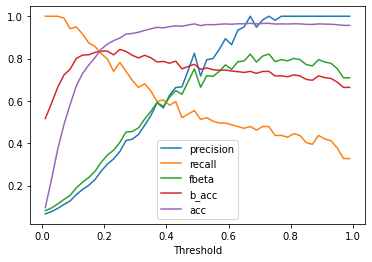

TP: 57, TN: 1735, FP: 0, FN: 62
TH: 0.67 precision: 1.000 recall: 0.479 fbeta: 0.821 b_acc: 0.739 acc: 0.967


In [17]:
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", step=2, truth_threshold=0.8)